# DA11 Preprocess
06/25/2023

NOTE: DA11 recording was started and stopped. All channels must be loaded individually, concatenated, saved, and reloaded as one mne file. This should only need to be done once. 

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import emd
import re

import warnings
warnings.filterwarnings('ignore')

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
import sys
sys.path.append('/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/scripts/saez_python_pipeline/LFPAnalysis/')

In [3]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

In [4]:
# Specify root directory for un-archived data and results 
base_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/'
anat_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/anat_recons/recon_labels/'
neural_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/'
behav_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/behavior_analysis/behavior_preprocessed/'

subj_id = 'DA11'
subj_format = ['nlx']
subj_site = ['UCD']


# Load and Concatenate Each Ch File

In [ ]:
#load one channel all copies of each
#check timesteps 
#concat as one and dict

### Load anat recon info to get probe names 

In [5]:
# Load the electrode localization data
anat_file = glob(f'{anat_dir}{subj_id}_labels.csv')[0]
elec_locs = pd.read_csv(anat_file)
# Sometimes there's extra columns with no entries: 
elec_locs = elec_locs[elec_locs.columns.drop(list(elec_locs.filter(regex='Unnamed')))]

elec_locs

,label,BN246label,x,y,z,mni_x,mni_y,mni_z,gm,NMM,Anat,AnatMacro,BN246,YBA_1,ManualExamination
0,LAM1,rHipp_L,-23.583114,13.677539,-14.846665,-21.787677,-3.071038,-27.563982,Gray,Left Amygdala,Amygdala (LB),L ParaHippocampal Gyrus,L Hipp,Left amygdala inferior,NaN
1,LAM2,lAmyg_L,-28.379682,12.878366,-14.846665,-26.646692,-4.016142,-27.115331,Gray,Left Amygdala,Amygdala (LB),L ParaHippocampal Gyrus,L Amyg,Left amygdala inferior,NaN
2,LAM3,lAmyg_L,-33.176250,12.079194,-14.846665,-31.485298,-4.962499,-26.790415,Gray,Left Amygdala,Amygdala (LB),L Hippocampus,L Amyg,Left amygdala inferior,NaN
3,LAM4,A20rv_L,-37.972818,11.280022,-15.246466,-36.333955,-5.878473,-26.979067,White,Left Cerebral White Matter,Unknown,L Fusiform Gyrus,L FuG,Unknown,OOB
4,LAM5,A20rv_L,-42.769386,10.081264,-15.246466,-41.307728,-7.013807,-26.690822,White,Left Cerebral White Matter,Unknown,L Inferior Temporal Gyrus,L FuG,Unknown,WM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,RTT5,A20r_R,36.773699,19.271744,-22.442895,39.412887,0.344354,-36.125057,White,Right ITG inferior temporal gyrus,Unknown,R Inferior Temporal Gyrus,R ITG,Right inferior temporal pole C,WM
114,RTT6,A20iv_R,39.571697,14.876297,-21.643292,42.026220,-3.612829,-33.797227,White,Right Cerebral White Matter,Unknown,R Inferior Temporal Gyrus,R ITG,Unknown,WM
115,RTT7,A20iv_R,41.969981,10.880436,-21.243491,44.290563,-7.278455,-32.029983,White,Right Cerebral White Matter,Unknown,R Inferior Temporal Gyrus,R ITG,Right basal inferior temporal gyrus A,NaN
116,RTT8,A20iv_R,44.767979,6.484989,-20.443887,47.091041,-11.128435,-29.650420,White,Right Cerebral White Matter,Unknown,R Inferior Temporal Gyrus,R ITG,Unknown,WM


In [6]:
ch_names = list(elec_locs.label)
pattern = '[0-9]'
ch_names_no_num = [re.sub(pattern, '', i) for i in ch_names]
probe_names = np.unique(ch_names_no_num)

In [7]:
probe_names

array(['LAM', 'LHB', 'LHH', 'LTT\xa0.', 'RAC', 'RAM', 'RFP', 'RHB', 'RHH',
       'RIA', 'RIP', 'RSM', 'RTT'], dtype='<U5')

In [8]:
ch_names

['LAM1',
 'LAM2',
 'LAM3',
 'LAM4',
 'LAM5',
 'LAM6',
 'LAM7',
 'LAM8',
 'LAM9',
 'LHB1',
 'LHB2',
 'LHB3',
 'LHB4',
 'LHB5',
 'LHB6',
 'LHB7',
 'LHB8',
 'LHB9',
 'LHH1',
 'LHH2',
 'LHH3',
 'LHH4',
 'LHH5',
 'LHH6',
 'LHH7',
 'LHH8',
 'LHH9',
 'LTT\xa01.00',
 'LTT\xa02.00',
 'LTT\xa03.00',
 'LTT\xa04.00',
 'LTT\xa05.00',
 'LTT\xa06.00',
 'LTT\xa07.00',
 'LTT\xa08.00',
 'LTT\xa09.00',
 'RAC1',
 'RAC10',
 'RAC2',
 'RAC3',
 'RAC4',
 'RAC5',
 'RAC6',
 'RAC7',
 'RAC8',
 'RAC9',
 'RAM1',
 'RAM2',
 'RAM3',
 'RAM4',
 'RAM5',
 'RAM6',
 'RAM7',
 'RAM8',
 'RAM9',
 'RFP1',
 'RFP2',
 'RFP3',
 'RFP4',
 'RFP5',
 'RFP6',
 'RFP7',
 'RFP8',
 'RFP9',
 'RHB1',
 'RHB2',
 'RHB3',
 'RHB4',
 'RHB5',
 'RHB6',
 'RHB7',
 'RHB8',
 'RHB9',
 'RHH1',
 'RHH2',
 'RHH3',
 'RHH4',
 'RHH5',
 'RHH6',
 'RHH7',
 'RHH8',
 'RHH9',
 'RIA1',
 'RIA10',
 'RIA2',
 'RIA3',
 'RIA4',
 'RIA5',
 'RIA6',
 'RIA7',
 'RIA8',
 'RIA9',
 'RIP1',
 'RIP10',
 'RIP2',
 'RIP3',
 'RIP4',
 'RIP5',
 'RIP6',
 'RIP7',
 'RIP8',
 'RIP9',
 'RSM1',
 'RSM2'

### need to use ch_names to iteratively load, concatenate, and resave each split channel 

In [18]:
chan_names = ch_names  + ['Photodiode'] #add photodiode to list of channels 

In [19]:
chan_names

['LAM1',
 'LAM2',
 'LAM3',
 'LAM4',
 'LAM5',
 'LAM6',
 'LAM7',
 'LAM8',
 'LAM9',
 'LHB1',
 'LHB2',
 'LHB3',
 'LHB4',
 'LHB5',
 'LHB6',
 'LHB7',
 'LHB8',
 'LHB9',
 'LHH1',
 'LHH2',
 'LHH3',
 'LHH4',
 'LHH5',
 'LHH6',
 'LHH7',
 'LHH8',
 'LHH9',
 'LTT\xa01.00',
 'LTT\xa02.00',
 'LTT\xa03.00',
 'LTT\xa04.00',
 'LTT\xa05.00',
 'LTT\xa06.00',
 'LTT\xa07.00',
 'LTT\xa08.00',
 'LTT\xa09.00',
 'RAC1',
 'RAC10',
 'RAC2',
 'RAC3',
 'RAC4',
 'RAC5',
 'RAC6',
 'RAC7',
 'RAC8',
 'RAC9',
 'RAM1',
 'RAM2',
 'RAM3',
 'RAM4',
 'RAM5',
 'RAM6',
 'RAM7',
 'RAM8',
 'RAM9',
 'RFP1',
 'RFP2',
 'RFP3',
 'RFP4',
 'RFP5',
 'RFP6',
 'RFP7',
 'RFP8',
 'RFP9',
 'RHB1',
 'RHB2',
 'RHB3',
 'RHB4',
 'RHB5',
 'RHB6',
 'RHB7',
 'RHB8',
 'RHB9',
 'RHH1',
 'RHH2',
 'RHH3',
 'RHH4',
 'RHH5',
 'RHH6',
 'RHH7',
 'RHH8',
 'RHH9',
 'RIA1',
 'RIA10',
 'RIA2',
 'RIA3',
 'RIA4',
 'RIA5',
 'RIA6',
 'RIA7',
 'RIA8',
 'RIA9',
 'RIP1',
 'RIP10',
 'RIP2',
 'RIP3',
 'RIP4',
 'RIP5',
 'RIP6',
 'RIP7',
 'RIP8',
 'RIP9',
 'RSM1',
 'RSM2'

In [20]:
load_path = f'{neural_dir}{subj_id}/raw_nlx/'

ncs_files = [x for x in glob(f'{load_path}/*.ncs')]

In [21]:
ncs_files

['/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/DA11/raw_nlx/RIA7_0007.ncs',
 '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/DA11/raw_nlx/LAM9_0007.ncs',
 '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/DA11/raw_nlx/RIA6_0007.ncs',
 '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/DA11/raw_nlx/LAM8_0007.ncs',
 '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/DA11/raw_nlx/LHB9_0005.ncs',
 '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/DA11/raw_nlx/LHB8_0005.ncs',
 '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/DA11/raw_nlx/RSM3_0005.ncs',
 '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/DA11/raw_nlx/RAC4_0005.ncs',
 '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/DA11/raw_nlx/RSM2_0005.ncs',
 '/Users/alexandraf

In [22]:
ch_file_dict = {} #dictionary mapping electrode name to the its 2 corresponding data files 

for ch in chan_names:
    ch_files = [f for f in ncs_files if ch == f.split('/')[-1].replace('.ncs','').split('_')[0]] #was saving ch 10 with ch 1 before
    ch_file_dict[ch]=ch_files
    
ch_file_dict

{'LAM1': ['/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/DA11/raw_nlx/LAM1_0007.ncs',
  '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/DA11/raw_nlx/LAM1_0006.ncs',
  '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/DA11/raw_nlx/LAM1_0005.ncs'],
 'LAM2': ['/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/DA11/raw_nlx/LAM2_0005.ncs',
  '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/DA11/raw_nlx/LAM2_0007.ncs',
  '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/DA11/raw_nlx/LAM2_0006.ncs'],
 'LAM3': ['/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/DA11/raw_nlx/LAM3_0005.ncs',
  '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/DA11/raw_nlx/LAM3_0007.ncs',
  '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/DA11/raw_nlx/

In [23]:
ch_file_counts = {}

for ch in ch_file_dict:
    ch_file_counts[ch] = len(ch_file_dict[ch])

In [24]:
ch_file_counts

{'LAM1': 3,
 'LAM2': 3,
 'LAM3': 3,
 'LAM4': 3,
 'LAM5': 3,
 'LAM6': 3,
 'LAM7': 3,
 'LAM8': 3,
 'LAM9': 3,
 'LHB1': 3,
 'LHB2': 3,
 'LHB3': 3,
 'LHB4': 3,
 'LHB5': 3,
 'LHB6': 3,
 'LHB7': 3,
 'LHB8': 3,
 'LHB9': 3,
 'LHH1': 3,
 'LHH2': 3,
 'LHH3': 3,
 'LHH4': 3,
 'LHH5': 3,
 'LHH6': 3,
 'LHH7': 3,
 'LHH8': 3,
 'LHH9': 3,
 'LTT\xa01.00': 0,
 'LTT\xa02.00': 0,
 'LTT\xa03.00': 0,
 'LTT\xa04.00': 0,
 'LTT\xa05.00': 0,
 'LTT\xa06.00': 0,
 'LTT\xa07.00': 0,
 'LTT\xa08.00': 0,
 'LTT\xa09.00': 0,
 'RAC1': 3,
 'RAC10': 3,
 'RAC2': 3,
 'RAC3': 3,
 'RAC4': 3,
 'RAC5': 3,
 'RAC6': 3,
 'RAC7': 3,
 'RAC8': 3,
 'RAC9': 3,
 'RAM1': 3,
 'RAM2': 3,
 'RAM3': 3,
 'RAM4': 3,
 'RAM5': 3,
 'RAM6': 3,
 'RAM7': 3,
 'RAM8': 3,
 'RAM9': 3,
 'RFP1': 3,
 'RFP2': 3,
 'RFP3': 3,
 'RFP4': 3,
 'RFP5': 3,
 'RFP6': 3,
 'RFP7': 3,
 'RFP8': 3,
 'RFP9': 3,
 'RHB1': 3,
 'RHB2': 3,
 'RHB3': 3,
 'RHB4': 3,
 'RHB5': 3,
 'RHB6': 3,
 'RHB7': 3,
 'RHB8': 3,
 'RHB9': 3,
 'RHH1': 3,
 'RHH2': 3,
 'RHH3': 3,
 'RHH4': 3,
 'RHH5': 3,


In [25]:
### empty vecs to load data into 

ch_name = [] #channel name
srs = [] #sampling rate
signals = [] #data
ch_type = []

In [27]:
ch

'LTT\xa01.00'

In [26]:
#### add data and sampling rate to signals, srs, ch_name 

# make concatenated dictionaries for each channel 
#load nlx files for each channel
#make new dict with info and data for each channel
#make sure to join data in correct order (should be _0005 then _0007)

ch_data_dict = {}
ch_time_dict = {}

for ch in ch_file_dict:

    #load ncs files for the channel
    file1 = nlx_utils.load_ncs(ch_file_dict[ch][0])
    file2 = nlx_utils.load_ncs(ch_file_dict[ch][1])
    file3 = nlx_utils.load_ncs(ch_file_dict[ch][2])
    files_list = [file1,file2,file3]
    start_times = [file1['time'][0],file2['time'][0],file3['time'][0]] 
    first_idx = np.argmin(start_times) #for this patient I can remove earliest file because I verified that this was the file that needed to be removed 
    first_file = files_list[first_idx]
    last_idx = np.argmax(start_times)
    third_file = files_list[last_idx]
    middle_idx = [n for n in range(3) if (n!=first_idx) & (n!=last_idx)][0]
    second_file = files_list[middle_idx]

#     #load ncs files for the channel
#     file1 = nlx_utils.load_ncs(ch_file_dict[ch][0])
#     file2 = nlx_utils.load_ncs(ch_file_dict[ch][1])
#     #check which file comes first - time between files should be shorter if order is correct
#     if (file1['time'][0] - file2['time'][-1]) > (file2['time'][0] - file1['time'][-1]): #if first difference larger - file 1 comes first, if second difference is larger file 2 comes first 
#         first_file = file1
#         second_file = file2
#     elif (file1['time'][0] - file2['time'][-1]) < (file2['time'][0] - file1['time'][-1]):
#             first_file = file2
#             second_file = file1
#     else:
#         print('cannot identify file order for ',ch)

    #concatenate data and timestamps from each channel
    data_array = np.hstack((first_file['data'],second_file['data'],third_file['data']))
    time_array = np.hstack((first_file['time'],second_file['time'],third_file['time']))
    #save into dictionaries (just in case this is needed again or needs to be checked)
    ch_data_dict[ch] = data_array
    ch_time_dict[ch] = time_array
    samp_rate = first_file['sampling_rate']
    #add ch info, samp rate, and concatenated data array to master list
    ch_name.append(ch)
    srs.append(samp_rate)
    signals.append(data_array)
    if ch == 'Photodiode':
        ch_type.append('stim')
    else:
        ch_type.append('seeg')

    
    
    
    

IndexError: list index out of range

In [ ]:
srs

In [18]:
signals

[array([ -5453,  -6021,  -6473, ..., -19850, -22971, -26033], dtype=int16),
 array([ 2299,  2987,  3572, ..., 19449, 24359, 28436], dtype=int16),
 array([ 2586,  3220,  3759, ..., 17543, 22466, 26537], dtype=int16),
 array([ 2903,  3569,  4127, ..., 17911, 22816, 26946], dtype=int16),
 array([ 2202,  2833,  3372, ..., 18662, 23511, 27573], dtype=int16),
 array([ 2194,  2822,  3387, ..., 18460, 23360, 27435], dtype=int16),
 array([ 1311,  1950,  2527, ..., 18007, 22880, 26899], dtype=int16),
 array([ 1331,  1993,  2563, ..., 18012, 22861, 26874], dtype=int16),
 array([ 4682,  5334,  5888, ..., 19932, 24827, 28895], dtype=int16),
 array([ 3271,  3907,  4538, ..., 21288, 26218, 30006], dtype=int16),
 array([ 2611,  3186,  3748, ..., 19500, 24352, 28119], dtype=int16),
 array([ 3534,  4157,  4698, ..., 20552, 25398, 29197], dtype=int16),
 array([ 3220,  3915,  4510, ..., 19053, 23987, 27827], dtype=int16),
 array([ 2363,  2985,  3606, ..., 17482, 22384, 26189], dtype=int16),
 array([ 1429,

In [19]:
for ch,s in list(zip(ch_name,signals)):
    print(ch,s.shape)

LAM1 (20877824,)
LAM2 (20877824,)
LAM3 (20877824,)
LAM4 (20877824,)
LAM5 (20877824,)
LAM6 (20877824,)
LAM7 (20877824,)
LAM8 (20877824,)
LAM9 (20877824,)
LHB1 (20877824,)
LHB2 (20877824,)
LHB3 (20877824,)
LHB4 (20877824,)
LHB5 (20877824,)
LHB6 (20877824,)
LHB7 (20877824,)
LHB8 (20877824,)
LHB9 (20877824,)
LHH1 (20877824,)
LHH2 (20877824,)
LHH3 (20877824,)
LHH4 (20877824,)
LHH5 (20877824,)
LHH6 (20877824,)
LHH7 (20877824,)
LHH8 (20877824,)
LHH9 (20877824,)
LTT1 (20877824,)
LTT2 (20877824,)
LTT3 (20877824,)
LTT4 (20877824,)
LTT5 (20877824,)
LTT6 (20877824,)
LTT7 (20877824,)
LTT8 (20877824,)
LTT9 (20877824,)
RAC1 (20877824,)
RAC10 (20877824,)
RAC2 (20877824,)
RAC3 (20877824,)
RAC4 (20877824,)
RAC5 (20877824,)
RAC6 (20877824,)
RAC7 (20877824,)
RAC8 (20877824,)
RAC9 (20877824,)
RAM1 (20877824,)
RAM2 (20877824,)
RAM3 (20877824,)
RAM4 (20877824,)
RAM5 (20877824,)
RAM6 (20877824,)
RAM7 (20877824,)
RAM8 (20877824,)
RAM9 (20877824,)
RFP1 (20877824,)
RFP2 (20877824,)
RFP3 (20877824,)
RFP4 (2087782

In [42]:
#save dictionary of channel > data mappings 
import pickle 

dict_save_path = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/DA11/raw_ch_dict/'

# create a binary pickle file 
f = open(f'{dict_save_path}concat_data_06252023.pkl',"wb")
# # write the python object (dict) to pickle file
pickle.dump(ch_data_dict,f)
# # close file
f.close()

# create a binary pickle file 
f = open(f'{dict_save_path}concat_time_06252023.pkl',"wb")
# # write the python object (dict) to pickle file
pickle.dump(ch_time_dict,f)
# # close file
f.close()


## Make mne_data from concatenated signals list

In [20]:
target_sr = 500 #downsampling to 500 to be consistent with other data - alternative = np.min(srs)
mne_data_resampled = []

In [21]:
### resampling to 500Hz

for sr in np.unique(srs):
    ch_ix = np.where(srs==sr)[0].astype(int)
    info = mne.create_info([x for ix, x in enumerate(ch_name) if ix in ch_ix], sr)
    mne_data_temp = mne.io.RawArray([x for ix, x in enumerate(signals) if ix in ch_ix], info)
    if sr != target_sr:
        # resample down to one sample rate 
        mne_data_temp.resample(sfreq=target_sr, npad='auto', n_jobs=-1)
        mne_data_resampled.append(mne_data_temp)
    else: 
        mne_data = mne_data_temp
        

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 119 out of 119 | elapsed:  2.2min finished


In [23]:
### make sure timing is aligned post resampling 

#Because of the resampling, the end timings might not match perfectly:https://github.com/mne-tools/mne-python/issues/8257

if mne_data_resampled[0].tmax > mne_data_temp.tmax:
    mne_data_resampled[0].crop(tmin=0, tmax=mne_data_temp.tmax)
elif mne_data_resampled[0].tmax < mne_data_temp.tmax:
    mne_data_temp.crop(tmin=0, tmax=mne_data_resampled[0].tmax)
    

In [24]:
mne_data = mne_data_resampled[0]  #mne_data.add_channels([mne_data_temp]) to add more channels input mne object as list
mne_data

<RawArray | 119 x 2609728 (5219.5 s), ~2.31 GB, data loaded>

In [25]:
mne_data.ch_names

['LAM1',
 'LAM2',
 'LAM3',
 'LAM4',
 'LAM5',
 'LAM6',
 'LAM7',
 'LAM8',
 'LAM9',
 'LHB1',
 'LHB2',
 'LHB3',
 'LHB4',
 'LHB5',
 'LHB6',
 'LHB7',
 'LHB8',
 'LHB9',
 'LHH1',
 'LHH2',
 'LHH3',
 'LHH4',
 'LHH5',
 'LHH6',
 'LHH7',
 'LHH8',
 'LHH9',
 'LTT1',
 'LTT2',
 'LTT3',
 'LTT4',
 'LTT5',
 'LTT6',
 'LTT7',
 'LTT8',
 'LTT9',
 'RAC1',
 'RAC10',
 'RAC2',
 'RAC3',
 'RAC4',
 'RAC5',
 'RAC6',
 'RAC7',
 'RAC8',
 'RAC9',
 'RAM1',
 'RAM2',
 'RAM3',
 'RAM4',
 'RAM5',
 'RAM6',
 'RAM7',
 'RAM8',
 'RAM9',
 'RFP1',
 'RFP2',
 'RFP3',
 'RFP4',
 'RFP5',
 'RFP6',
 'RFP7',
 'RFP8',
 'RFP9',
 'RHB1',
 'RHB2',
 'RHB3',
 'RHB4',
 'RHB5',
 'RHB6',
 'RHB7',
 'RHB8',
 'RHB9',
 'RHH1',
 'RHH2',
 'RHH3',
 'RHH4',
 'RHH5',
 'RHH6',
 'RHH7',
 'RHH8',
 'RHH9',
 'RIA1',
 'RIA10',
 'RIA2',
 'RIA3',
 'RIA4',
 'RIA5',
 'RIA6',
 'RIA7',
 'RIA8',
 'RIA9',
 'RIP1',
 'RIP10',
 'RIP2',
 'RIP3',
 'RIP4',
 'RIP5',
 'RIP6',
 'RIP7',
 'RIP8',
 'RIP9',
 'RSM1',
 'RSM2',
 'RSM3',
 'RSM4',
 'RSM5',
 'RSM6',
 'RTT1',
 'RTT10',
 'RTT2

## Notch Filter Line Noise

In [26]:
mne_data.info['line_freq'] = 60
# Notch out 60 Hz noise and harmonics 
mne_data.notch_filter(freqs=(60, 120, 180, 240),picks = mne_data.ch_names)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 119 out of 119 | elapsed:    6.6s finished


<RawArray | 119 x 2609728 (5219.5 s), ~2.31 GB, data loaded>

In [27]:
#make mne_names lowercase 
new_name_dict = {x:x.replace(" ", "").lower() for x in mne_data.ch_names}
mne_data.rename_channels(new_name_dict) 

<RawArray | 119 x 2609728 (5219.5 s), ~2.31 GB, data loaded>

## Examine photodiode

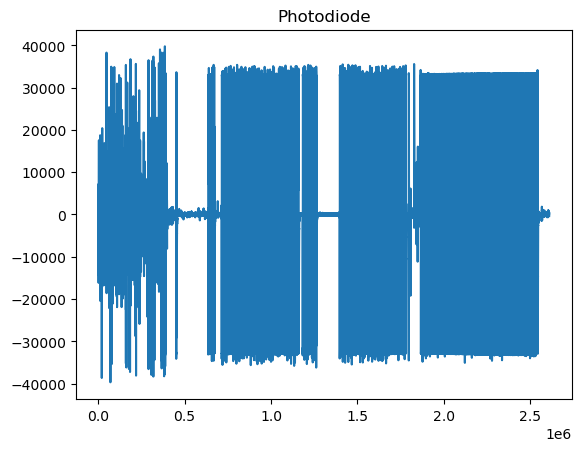

In [28]:
# Sanity check the photodiode
trig_ix = mne_data.ch_names.index('photodiode')
plt.plot(mne_data._data[trig_ix,]) #hopefully 
plt.title("Photodiode")
plt.show()

In [29]:
mne_data.save(f'{neural_dir}{subj_id}/photodiode.fif', picks='photodiode', overwrite=True)

## Anat Recon Info


In [30]:
# Load the electrode localization data
anat_file = glob(f'{anat_dir}{subj_id}_labels.csv')[0]
elec_locs = pd.read_csv(anat_file)
# Sometimes there's extra columns with no entries: 
elec_locs = elec_locs[elec_locs.columns.drop(list(elec_locs.filter(regex='Unnamed')))]

elec_locs

,label,BN246label,x,y,z,mni_x,mni_y,mni_z,gm,NMM,Anat,AnatMacro,BN246,YBA_1,Manual Examination
0,LAM1,rHipp_L,-23.583114,13.677539,-14.846665,-21.787677,-3.071038,-27.563982,Gray,Left Amygdala,Amygdala (LB),L ParaHippocampal Gyrus,L Hipp,Left amygdala inferior,NaN
1,LAM2,lAmyg_L,-28.379682,12.878366,-14.846665,-26.646692,-4.016142,-27.115331,Gray,Left Amygdala,Amygdala (LB),L ParaHippocampal Gyrus,L Amyg,Left amygdala inferior,NaN
2,LAM3,lAmyg_L,-33.176250,12.079194,-14.846665,-31.485298,-4.962499,-26.790415,Gray,Left Amygdala,Amygdala (LB),L Hippocampus,L Amyg,Left amygdala inferior,NaN
3,LAM4,A20rv_L,-37.972818,11.280022,-15.246466,-36.333955,-5.878473,-26.979067,White,Left Cerebral White Matter,Unknown,L Fusiform Gyrus,L FuG,Unknown,OOB
4,LAM5,A20rv_L,-42.769386,10.081264,-15.246466,-41.307728,-7.013807,-26.690822,White,Left Cerebral White Matter,Unknown,L Inferior Temporal Gyrus,L FuG,Unknown,WM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,RTT5,A20r_R,36.773699,19.271744,-22.442895,39.412887,0.344354,-36.125057,White,Right ITG inferior temporal gyrus,Unknown,R Inferior Temporal Gyrus,R ITG,Right inferior temporal pole C,WM
114,RTT6,A20iv_R,39.571697,14.876297,-21.643292,42.026220,-3.612829,-33.797227,White,Right Cerebral White Matter,Unknown,R Inferior Temporal Gyrus,R ITG,Unknown,WM
115,RTT7,A20iv_R,41.969981,10.880436,-21.243491,44.290563,-7.278455,-32.029983,White,Right Cerebral White Matter,Unknown,R Inferior Temporal Gyrus,R ITG,Right basal inferior temporal gyrus A,NaN
116,RTT8,A20iv_R,44.767979,6.484989,-20.443887,47.091041,-11.128435,-29.650420,White,Right Cerebral White Matter,Unknown,R Inferior Temporal Gyrus,R ITG,Unknown,WM


In [31]:
anat_names = list(elec_locs.label.str.lower())
sum([ch not in mne_data.ch_names for ch in anat_names]) #if there are no missing channels, sum = 0. if sum >0, find the missing elecs
print([ch for ch in mne_data.ch_names if ch not in anat_names ]) #print extra channels in mne_data.ch_names and make sure none of them are neural channels (will be EEG etc.)

['photodiode']


In [32]:
new_mne_names, unmatched_names, unmatched_seeg = lfp_preprocess_utils.match_elec_names(mne_data.ch_names, elec_locs.label)




In [33]:
new_mne_names

['lam1',
 'lam2',
 'lam3',
 'lam4',
 'lam5',
 'lam6',
 'lam7',
 'lam8',
 'lam9',
 'lhb1',
 'lhb2',
 'lhb3',
 'lhb4',
 'lhb5',
 'lhb6',
 'lhb7',
 'lhb8',
 'lhb9',
 'lhh1',
 'lhh2',
 'lhh3',
 'lhh4',
 'lhh5',
 'lhh6',
 'lhh7',
 'lhh8',
 'lhh9',
 'ltt1',
 'ltt2',
 'ltt3',
 'ltt4',
 'ltt5',
 'ltt6',
 'ltt7',
 'ltt8',
 'ltt9',
 'rac1',
 'rac10',
 'rac2',
 'rac3',
 'rac4',
 'rac5',
 'rac6',
 'rac7',
 'rac8',
 'rac9',
 'ram1',
 'ram2',
 'ram3',
 'ram4',
 'ram5',
 'ram6',
 'ram7',
 'ram8',
 'ram9',
 'rfp1',
 'rfp2',
 'rfp3',
 'rfp4',
 'rfp5',
 'rfp6',
 'rfp7',
 'rfp8',
 'rfp9',
 'rhb1',
 'rhb2',
 'rhb3',
 'rhb4',
 'rhb5',
 'rhb6',
 'rhb7',
 'rhb8',
 'rhb9',
 'rhh1',
 'rhh2',
 'rhh3',
 'rhh4',
 'rhh5',
 'rhh6',
 'rhh7',
 'rhh8',
 'rhh9',
 'ria1',
 'ria10',
 'ria2',
 'ria3',
 'ria4',
 'ria5',
 'ria6',
 'ria7',
 'ria8',
 'ria9',
 'rip1',
 'rip10',
 'rip2',
 'rip3',
 'rip4',
 'rip5',
 'rip6',
 'rip7',
 'rip8',
 'rip9',
 'rsm1',
 'rsm2',
 'rsm3',
 'rsm4',
 'rsm5',
 'rsm6',
 'rtt1',
 'rtt10',
 'rtt2

In [34]:
unmatched_names

[]

In [35]:
unmatched_seeg

[]

In [36]:
# Note, there is surface EEG data that we should separately indicate from the sEEG:
right_seeg_names = [i for i in mne_data.ch_names if i.startswith('r')]
left_seeg_names = [i for i in mne_data.ch_names if i.startswith('l')]
print(f'We have a total of', len(left_seeg_names), 'left &', len(right_seeg_names), 'right' 'sEEG electrodes')
print(f'We have a total of {len(left_seeg_names) + len(right_seeg_names)} sEEG electrodes')


We have a total of 36 left & 82 rightsEEG electrodes
We have a total of 118 sEEG electrodes


In [37]:
# Set channel types:
seeg_names = [x.lower() for x in mne_data.ch_names]
sEEG_mapping_dict = {f'{x}':'seeg' for x in seeg_names}
trig_mapping_dict = {'photodiode':'stim'} #'stim test1-ref' 'Stim TEST1-REF' stim stands for stimulus 
mne_data.set_channel_types(sEEG_mapping_dict)
mne_data.set_channel_types(trig_mapping_dict)

<RawArray | 119 x 2609728 (5219.5 s), ~2.31 GB, data loaded>

In [38]:
# make montage (convert mm to m)

montage = mne.channels.make_dig_montage(ch_pos=dict(zip(elec_locs.label, 
                                                        elec_locs[['mni_x', 'mni_y', 'mni_z']].to_numpy(dtype=float)/1000)),
                                        coord_frame='mni_tal')

mne_data.set_montage(montage, match_case=False, on_missing='warn')

<RawArray | 119 x 2609728 (5219.5 s), ~2.31 GB, data loaded>

### Detect bad channels - detect_bad_elecs function auto detects, then we validate manually 

In [39]:
bads = lfp_preprocess_utils.detect_bad_elecs(mne_data, sEEG_mapping_dict)
mne_data.info['bads'] = bads

In [41]:
bads
bads = bads[1:]
bads

['rac3', 'rac6', 'rfp1', 'rsm4']

In [42]:
ch_names = list(elec_locs.label.str.lower())
pattern = '[0-9]'
ch_names_no_num = [re.sub(pattern, '', i) for i in ch_names]
probe_names = np.unique(ch_names_no_num)

In [43]:
probe_names

array(['lam', 'lhb', 'lhh', 'ltt', 'rac', 'ram', 'rfp', 'rhb', 'rhh',
       'ria', 'rip', 'rsm', 'rtt'], dtype='<U3')

In [44]:
probe_ch_counts = {} #need this to select channel number for visualization
for p in probe_names:
    c = ch_names_no_num.count(p)
    probe_ch_counts[p] = c

In [45]:
probe_ch_counts

{'lam': 9,
 'lhb': 9,
 'lhh': 9,
 'ltt': 9,
 'rac': 10,
 'ram': 9,
 'rfp': 9,
 'rhb': 9,
 'rhh': 9,
 'ria': 10,
 'rip': 10,
 'rsm': 6,
 'rtt': 10}

<IPython.core.display.Javascript object>


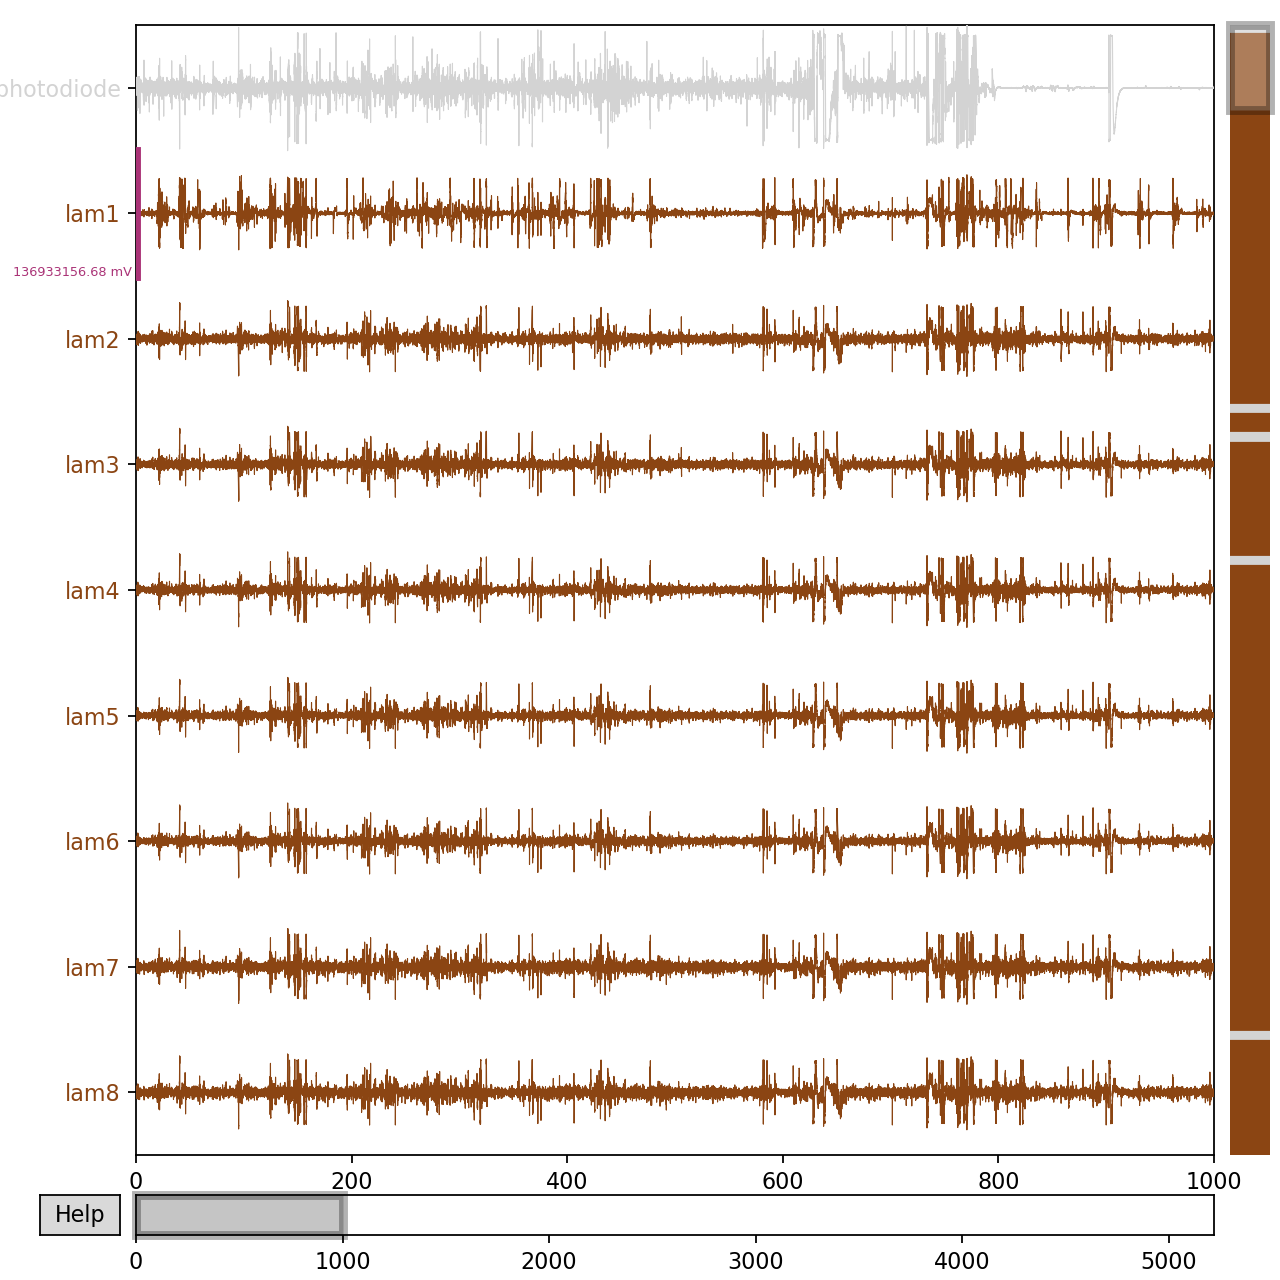

<IPython.core.display.Javascript object>


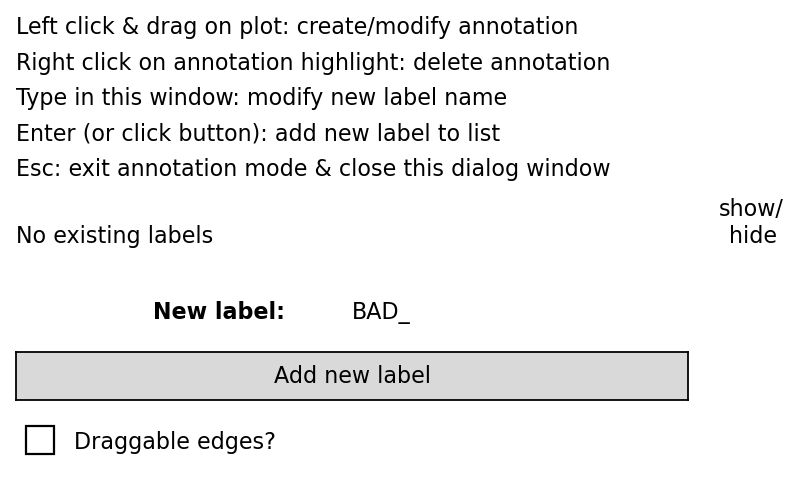

In [46]:
%matplotlib notebook
fig = mne_data.plot(start=0, duration=1000, n_channels=9, scalings=mne_data._data.max())
fig.fake_keypress('a')

In [47]:
#set bad channel info 
bad_ch = []


In [48]:
#manually set bads because doing it in the plot is too buggy
mne_data.info['bads'] = bad_ch

In [49]:
mne_data.info #sanity check that bads info saved

<Info | 9 non-empty values
 bads: []
 ch_names: lam1, lam2, lam3, lam4, lam5, lam6, lam7, lam8, lam9, lhb1, ...
 chs: 118 sEEG, 1 Stimulus
 custom_ref_applied: False
 dig: 118 items (118 EEG)
 highpass: 0.0 Hz
 line_freq: 60.0
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 119
 projs: []
 sfreq: 500.0 Hz
>

### Rereference data to wm electrodes

In [50]:
unmatched_seeg = [] #need this to run script, also need site = 'MSSM' because davis site specificity hasn't been implemented yet 

In [51]:
anat_file = glob(f'{anat_dir}{subj_id}_labels.csv')[0]

anode_list, cathode_list, drop_wm_channels, oob_channels = lfp_preprocess_utils.wm_ref(mne_data=mne_data, 
                                                                                elec_path=anat_file, 
                                                                                unmatched_seeg = unmatched_seeg,
                                                                                bad_channels=mne_data.info['bads'],
                                                                                      site = 'MSSM')

In [52]:
oob_channels

['lhb9', 'lhh9']

In [53]:
#add oob channels to bad channels list
bad_ch = bad_ch + oob_channels
bad_ch = list(np.unique(bad_ch))
mne_data.info['bads'] = bad_ch

In [54]:
mne_data.info['bads'] #needed to rerun plotting function to find this again?

['lhb9', 'lhh9']

In [55]:
mne_data.save(f'{neural_dir}{subj_id}/lfp_data.fif')

In [56]:
mne_data_reref = mne.set_bipolar_reference(mne_data, 
                      anode=anode_list, 
                      cathode=cathode_list,
                      copy=True)

In [57]:
mne_data_reref

<RawArray | 92 x 2609728 (5219.5 s), ~1.79 GB, data loaded>

In [63]:
mne_data_reref = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/wm_ref_ieeg.fif', preload=True)


In [66]:
mne_data_reref.drop_channels('photodiode')

<Raw | wm_ref_ieeg.fif, 91 x 2609728 (5219.5 s), ~1.77 GB, data loaded>

In [68]:
mne_data_reref.save(f'{neural_dir}{subj_id}/wm_ref_ieeg.fif',overwrite=True)